# Similaridade entre amostras de tecidos históricos

Considerando imagens de tecidos estampados do século XVIII, há uma demanda na comunidade de reproduções de figurinos pela identificação e comparação de tecidos atuais que possam ser usados na confecção de vestuário de época sem interferir na acurácia do traje.

A seguinte aplicação foi desenvolvida com o intuito de testar se dois descritores distintos (HOG e Haralick) seriam opções interessantes para avaliar similaride de estampas neste contexto.
No desenvolvimento do trabalho foram utilizadas bibliotecas da linguagem que oferecem o cálculo dos descritores e comparação entre os dados.

Importando bibliotecas para pré processamento das imagens, reconhecimento de texturas e cálculo de distâncias.

In [1]:
from PIL import Image
from PIL import ImageFilter
import imageio as im
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.feature import hog
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import mahotas as mt

Carregando imagens do computador, diretamente em escala de cinza. 

Foi optado neste caso por ignorar as características de cor das imagens, visto que no caso das amostras de tecidos originais de época há desbotamento da cor original, aumentando a complexidade de tal comparação sem a presença de alguma medida dos níveis distintos de desbotamento e desgaste dos tecidos.

As imagens carregadas estão separadas em trê pastas:
originais: contendo fotos de comprimentos de tecido originais do período.
correctexamples: contendo fotos de comprimentos de tecido atuais criados como reproduções diretas de tecidos originais e de outros tecidos que foram classificados pela comunidade de reproduções históricas como adequados para o contexto.
incorrectexamples: contendo fotos de comprimentos de tecido atuais que sejam inadequados para reprodução de trajes do século XVIII.


In [2]:
def loadImages(path):
    # return array of images
    path = os.getcwd() + '/' + path
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        #img = im.imread(os.path.join(path, image))
        img = Image.open(os.path.join(path, image)).convert('L')
        loadedImages.append(img)

    return loadedImages

correctExamples = loadImages("/images/correctexamples/")
incorrectExamples = loadImages("/images/incorrectexamples/")
originalExamples = loadImages("/images/originals/")


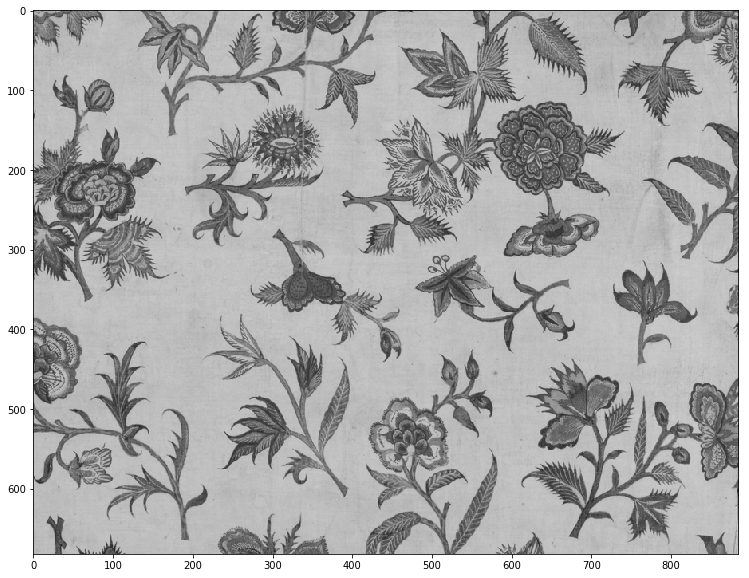

Imagem 1: Exemplo de tecido original


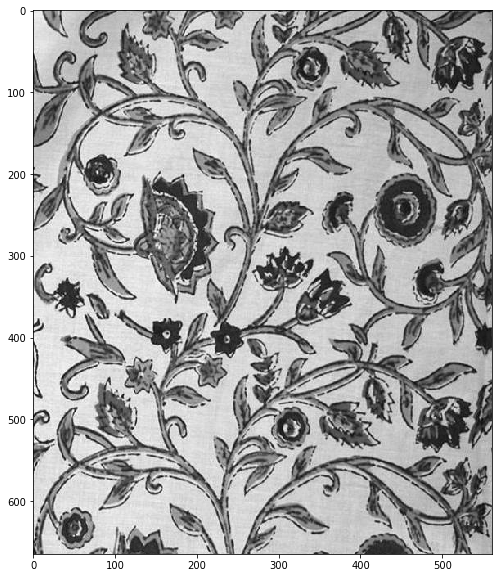

Imagem 2: Exemplo de reprodução adequada


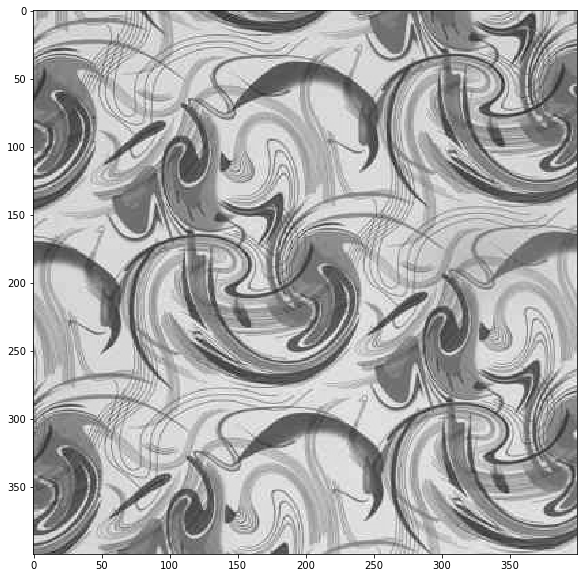

Imagem 3: Exemplo de tecido moderno de contexto distinto


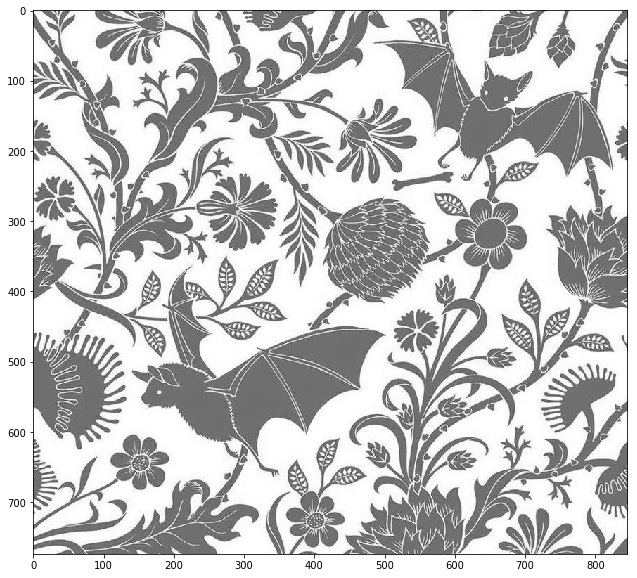

Imagem 4: Exemplo de tecido moderno similar a exemplos históricos


In [3]:
def plot(img):
    plt.figure(figsize=(20,10))
    imgplot = plt.imshow(img)

    plt.show()

plot(originalExamples[4])
print("Imagem 1: Exemplo de tecido original")
plot(correctExamples[0])
print("Imagem 2: Exemplo de reprodução adequada")
plot(incorrectExamples[0])
print("Imagem 3: Exemplo de tecido moderno de contexto distinto")
plot(incorrectExamples[5])
print("Imagem 4: Exemplo de tecido moderno similar a exemplos históricos")

Foi aplicado um pré processamento simples com filtro de mediana, com o objetivo de reduzir possíveis ruídos presentes nas imagens, tanto com relação as fotos, quanto sujeira ou algum desgaste menor presente na amostra.

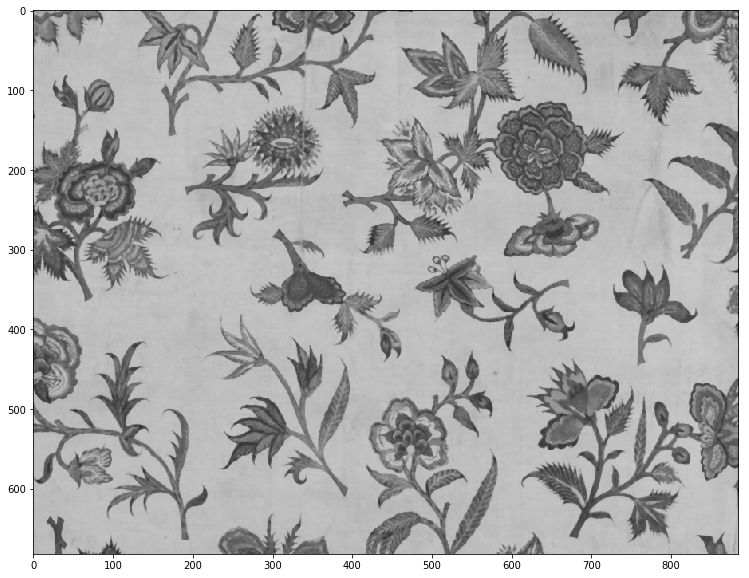

Imagem 5: Exemplo de tecido original pré-processado


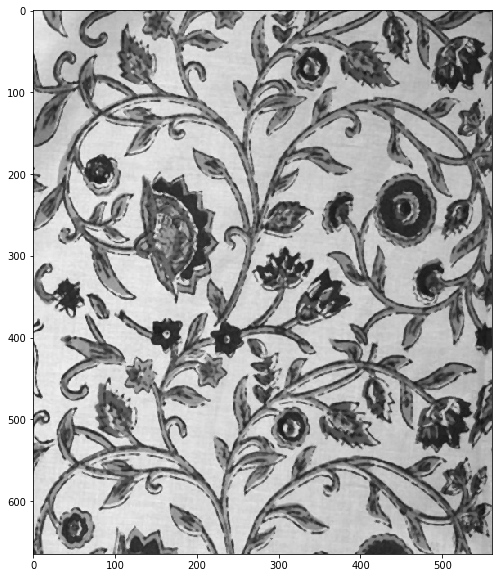

Imagem 6: Exemplo de reprodução adequada pré-processado


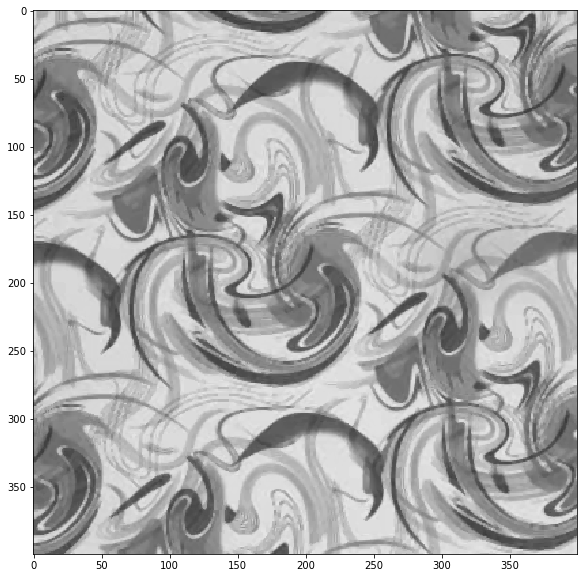

Imagem 7: Exemplo de tecido moderno de contexto distinto pré-processado


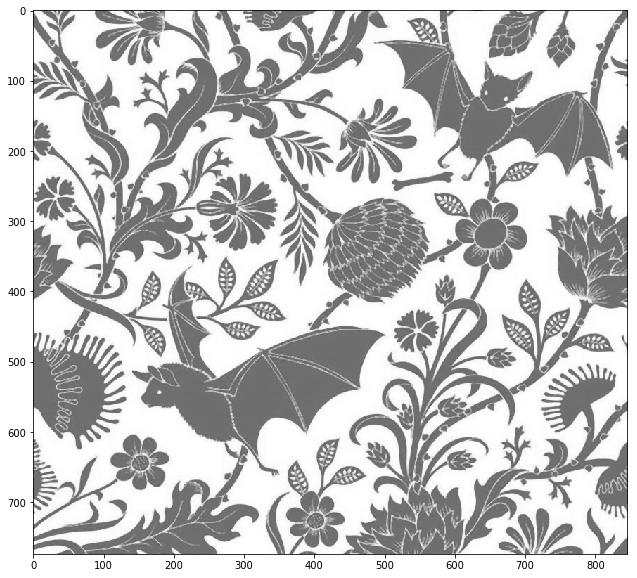

Imagem 8: Exemplo de tecido moderno similar a exemplos históricos pré-processado


In [4]:
def preprocess(imgs):
    imgs = [img.filter(ImageFilter.MedianFilter()) for img in imgs]
    return imgs
corrects = preprocess(correctExamples)
incorrects = preprocess(incorrectExamples)
originals = preprocess(originalExamples)

plot(originals[4])
print("Imagem 5: Exemplo de tecido original pré-processado")
plot(corrects[0])
print("Imagem 6: Exemplo de reprodução adequada pré-processado")
plot(incorrects[0])
print("Imagem 7: Exemplo de tecido moderno de contexto distinto pré-processado")
plot(incorrects[5])
print("Imagem 8: Exemplo de tecido moderno similar a exemplos históricos pré-processado")


In [5]:
def toNP(img):
    return np.asarray(img, dtype=np.uint8)

Gerando histograma de gradiente orientado (HOG) para todas as imagens.

In [6]:
def getBins(fd, num_bins = 20, max_val = 1, min_val = 0):
    total = max_val - min_val
    return [min_val + i*total/num_bins for i in range(num_bins + 1)]
def getHistogram(arr):
    hist, _ = np.histogram(arr , bins = getBins(arr))
    hist = hist / hist.max()
    return hist
def extractHistogram(img):
    fd, _ = hog(img, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')
    return getHistogram(fd)
correctsHistogram = [extractHistogram(img) for img in corrects]
incorrectsHistogram = [extractHistogram(img) for img in incorrects]
originalsHistogram = [extractHistogram(img) for img in originals]

Comparando a distância entre descritores de todas as imagens, calculando a porcentagem de acertos para imagens a partir de um threshold da distância, escolhido de forma empírica como 1.1 devido ao contexto.

O algoritmo utilizando HOG classificou corretamente 76% das imagens com correspondência, e 50% das imagens sem correspondência.

In [7]:
def plotHistogram(hist):
    plt.plot(hist)
    plt.show()
def compare(h1, h2):
    x = [[i, h1[i]]for i in range(len(h1))]
    y = [[i, h2[i]]for i in range(len(h2))]
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist
def compareAllBase(h1, base):
    dist = 10000
    for h2 in base:
        dist = min(dist, compare(h1, h2))
    return dist

shouldBeCorrect = [compareAllBase(hist, originalsHistogram) for hist in correctsHistogram]
shouldBeIncorrect = [compareAllBase(hist, originalsHistogram) for hist in incorrectsHistogram]

threshold = 1.1
n_correct_positive = len([x for x in shouldBeCorrect if x < threshold])
true_positive = n_correct_positive/len(corrects)
n_incorrect_positive = len([x for x in shouldBeIncorrect if x > threshold])
true_negative = n_incorrect_positive/len(incorrects)

print("Verdadeiros Positivos: {}".format(true_positive))
print("Verdadeiros Negativos: {}".format(true_negative))


Verdadeiros Positivos: 0.7692307692307693
Verdadeiros Negativos: 0.5


Como opção de comparação, um processo semelhante foi realizado com descritores de Haralick.

A partir do mesmo cálculo de distância, foi gerada a porcentagem de acertos para imagens a partir de um threshold da distância, escolhido de forma empírica como 900 devido ao contexto.

O algoritmo utilizando Haralick classificou corretamente 53% das imagens com correspondência, e 33% das imagens sem correspondência.

In [8]:
def extract_features_haralick(image):
    textures = mt.features.haralick(image)
    ht_mean  = textures.mean(axis=0)
    return ht_mean

correctsTexture = [extract_features_haralick(toNP(img)) for img in corrects]
incorrectsTexture = [extract_features_haralick(toNP(img)) for img in incorrects]
originalsTexture = [extract_features_haralick(toNP(img)) for img in originals]

shouldBeCorrect = [compareAllBase(textu, originalsTexture) for textu in correctsTexture]
shouldBeIncorrect = [compareAllBase(textu, originalsTexture) for textu in incorrectsTexture]

threshold = 900
n_correct_positive = len([x for x in shouldBeCorrect if x < threshold])
true_positive = n_correct_positive/len(corrects)
n_incorrect_positive = len([x for x in shouldBeIncorrect if x > threshold])
true_negative = n_incorrect_positive/len(incorrects)

print("Verdadeiros Positivos: {}".format(true_positive))
print("Verdadeiros Negativos: {}".format(true_negative))

Verdadeiros Positivos: 0.5384615384615384
Verdadeiros Negativos: 0.3333333333333333


A partir dos resultados obtidos, foi analisada a utilização de descritores de textura na comparação entre imagens de comprimentos de tecidos históricos e suas reproduções modernas.

Neste contexto, com uma base pequena (36 imagens, distribuidas entre as três categorias), os métodos de descrição de textura foram mais eficazes para classificar uma amostra correta do que uma amostra incorreta.

Algumas observações sobre o domínio podem ser apresentadas como possíveis explicações (a ser analisadas):

Existe grande variação entre os padrões de estampa dentro de cada grupo, dado a comum oferta de diversos motivos distintos, talvez causando a divergência de classificação.

Considerando tal variabilidade, é possível que as diferenças apresentadas pelas amostras incorretas não tenham sido suficientes para classifica-las como incorretas.

Tais observações poderiam ser testadas a partir de uma base maior e mais específica, talvez filtrando apenas amostras de um ano específico ou fabricante, porém neste caso temos a dificuldade de obter tais dados.